In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
import joblib
import pickle
import os
%matplotlib inline

In [2]:
#import required libraries for the data-analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

import pickle
import os
import joblib

In [3]:
# 1. Load and preprocess data
def load_and_preprocess_data(file_path):
    """
    Load the dataset and preprocess it:
    - Encode categorical variables.
    - Handle missing values:
      - For non-categorical data, check skewness to decide between mean and median imputation.
      - For categorical data, replace missing values with the most frequent value.
    - Ensure that 'Age' column values are absolute, and replace missing values with absolute mean/median.
    """
    data = pd.read_csv(file_path)

    # Replace spaces in column names with underscores
    data.columns = data.columns.str.replace(' ', '_')

    # Encode categorical variable 'Gender' Assigns 0 to female and 1 to male
    label_encoder = LabelEncoder()
    data['Gender'] = label_encoder.fit_transform(data['Gender'])

    # Handle 'Age' column specifically: Ensure absolute values and handle missing data
    if 'Age' in data.columns:
        data['Age'] = data['Age'].abs()  # Ensure 'Age' is absolute
        if data['Age'].isnull().sum() > 0:  # If there are missing values
            if abs(data['Age'].skew()) >= 0.5:  # Check for skewness
                # Replace with absolute median
                median_age = abs(data['Age'].median())
                data['Age'] = data['Age'].fillna(value=median_age)
            else:
                # Replace with absolute mean
                mean_age = abs(data['Age'].mean())
                data['Age'] = data['Age'].fillna(value=mean_age)

    # Handle missing values for other columns
    for column in data.columns:
        if column != 'Age':  # 'Age' already handled
            if data[column].dtype == 'object':  # Categorical data
                most_frequent = data[column].mode()[0]
                data[column] = data[column].fillna(value=most_frequent)
            else:  # Numeric data
                if data[column].isnull().sum() > 0:  # Only process columns with missing values
                    if abs(data[column].skew()) >= 0.5:  # Check for skewness
                        # Replace with absolute median
                        median_value = abs(data[column].median())
                        data[column] = data[column].fillna(value=median_value)
                    else:
                        # Replace with absolute mean
                        mean_value = abs(data[column].mean())
                        data[column] = data[column].fillna(value=mean_value)

    return data


In [4]:
# 2. Split the data into training and testing sets
def split_data(data, features, target):
    """
    Split the dataset into train and test sets.
    """
    X = data[features]
    y = data[target]
    return train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# 3. Build a pipeline for selected classification model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

def build_pipeline(model_name):
    """
    Build and return a pipeline with preprocessing and the chosen classification model.
    """
    model_dict = {
        'naive_bayes': GaussianNB(),
        'svm': SVC(probability=True, class_weight='balanced'),  # SVM needs `probability=True` for ROC curve
        'decision_tree': DecisionTreeClassifier(random_state=42)  # Added Decision Tree
    }

    if model_name not in model_dict:
        raise ValueError("Invalid model name. Choose from 'naive_bayes', 'svm', 'decision_tree'.")

    return Pipeline([
        ('scaler', StandardScaler()),  # Preprocessing step
        ('classifier', model_dict[model_name])  # Chosen model
    ])


In [6]:
# 4. Train the pipeline and make predictions
def train_and_evaluate_pipeline(pipeline, X_train, X_test, y_train, y_test):
    """
    Train the pipeline, predict, and evaluate the results.
    """
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    # Calculate various metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    return y_pred, y_proba, accuracy, precision, recall, f1, roc_auc

In [7]:
# 5. Plot confusion matrix
def plot_confusion_matrix(y_test, y_pred, model_name,target_name, title="Confusion Matrix"):
    """
    Plot and saves the confusion matrix using seaborn.
    """
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(model_name+target_name+'_CM'+'.jpg', dpi = 300)
    plt.show()

In [8]:
# 6. Plot ROC curve
def plot_roc_curve(y_test, y_proba,model_name,target_name, title="ROC Curve"):
    """
    Plot and saves the ROC curve using matplotlib.
    """
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, y_proba))
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.title(title)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.savefig(model_name+target_name+'_Roc'+'.jpg', dpi = 300)
    plt.show()

In [9]:
# 7. Hyperparameter tuning using GridSearchCV
from sklearn.model_selection import GridSearchCV

def tune_hyperparameters(X_train, y_train, model_name, k, scoring):
    """
    Perform hyperparameter tuning using GridSearchCV.
    """
    if model_name == 'naive_bayes':
        param_grid = {'classifier__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}
    elif model_name == 'svm':
        param_grid = {'classifier__C': [0.5, 1, 10], 'classifier__kernel': ['linear', 'rbf']}  # SVM hyperparameters
    elif model_name == 'decision_tree':
        param_grid = {
            'classifier__criterion': ['gini', 'entropy'],  # Split criteria
            'classifier__max_depth': [None, 10, 20, 30],  # Max depth of the tree
            'classifier__min_samples_split': [2, 5, 10],  # Min samples required to split
            'classifier__min_samples_leaf': [1, 2, 4]    # Min samples at a leaf node
        }
    else:
        raise ValueError("Invalid model name for hyperparameter tuning. Choose 'naive_bayes', 'svm', or 'decision_tree'.")

    grid_search = GridSearchCV(
        estimator=build_pipeline(model_name),
        param_grid=param_grid,
        cv=k,
        scoring=scoring
    )
    grid_search.fit(X_train, y_train)

    print(f"Best Parameters for {model_name}: {grid_search.best_params_}")
    return grid_search.best_estimator_


In [10]:
# 8. Compare metrics before and after hyperparameter tuning
def compare_metrics(before_metrics, after_metrics, model_name, traget_name):
    """
    Compare metrics before and after hyperparameter tuning.
    """
    print(f"\nMetrics Comparison for {model_name} (Before and After Hyperparameter Tuning):")
    print(f"{'Metric':<20}{'Before Tuning':<15}{'After Tuning':<15}")
    for metric, before, after in zip(["Accuracy", "Precision", "Recall", "F1 Score", "ROC-AUC"],before_metrics, after_metrics):
          print(f"{metric:<20}{before:<15.4f}{after:<15.4f}")
    # Plot comparison of metrics
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']
    before_values = before_metrics
    after_values = after_metrics

    plt.figure(figsize=(8, 6))
    x = range(len(metrics))
    plt.bar(x, before_values, width=0.4, label='Before Tuning', align='center')
    plt.bar(x, after_values, width=0.4, label='After Tuning', align='edge')
    plt.xticks(x, metrics)
    plt.title(f'Metrics Comparison for {model_name}')
    plt.ylabel('Scores')
    plt.legend()
    plt.savefig(model_name+target_name+'bar_plot'+'.jpg', dpi = 300)
    plt.show()

In [11]:
# 9. Save metrics to a file with the model name in the filename
def save_metrics_to_file(before_metrics, after_metrics, model_name, target_name, directory='./'):
    """
    Save metrics comparison before and after tuning to a file with the model name in the filename.
    """
    # Construct the filename dynamically based on model name and target
    filename = f"{model_name}_{target_name}_metrics_comparison.txt"

    # Metrics to be saved
    metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC-AUC"]

    # Open the file and write the metrics
    with open(filename, 'w') as file:  # 'w' mode to overwrite for a new file
        file.write(f"Metrics Comparison for {model_name.capitalize()} - {target_name}\n")
        file.write(f"{'Metric':<20}{'Before Tuning':<20}{'After Tuning':<20}\n")
        for metric, before, after in zip(metrics, before_metrics, after_metrics):
            file.write(f"{metric:<20}{before:<20.4f}{after:<20.4f}\n")
        file.write("\n")

    print(f"Metrics saved to {filename}")

In [12]:
# 10. Save model using pickle
def save_model(pipeline, model_name, target_name, directory='./'):
    """
    Save the trained pipeline to a file using pickle.

    Args:
        pipeline (Pipeline): The trained pipeline object.
        model_name (str): The name of the model (e.g., 'svm', 'naive_bayes').
        target_name (str): The target variable name (e.g., 'Gender', 'Ad_click').
        directory (str): Directory where the model file should be saved. Defaults to the current directory.

    Returns:
        str: The path to the saved model file.
    """
    # Ensure the directory exists
    os.makedirs(directory, exist_ok=True)

    # Construct the filename
    filename = os.path.join(directory, f"{model_name}_{target_name}_model.pkl")

    # Save the pipeline using pickle
    try:
        with open(filename, 'wb') as f:
            pickle.dump(pipeline, f)
        print(f"Model saved successfully to: {filename}")
    except Exception as e:
        print(f"Error saving model: {e}")
        return None

    return filename

'decision_tree'

Choose a model ('naive_bayes', 'svm', 'decision_tree'): decision_tree
---- Decision_tree Gender Prediction (Before Hyperparameter Tuning) ----
---- Hyperparameter Tuning for Decision_tree (Gender Prediction) ----
Best Parameters for decision_tree: {'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 2}

Metrics Comparison for decision_tree (Before and After Hyperparameter Tuning):
Metric              Before Tuning  After Tuning   
Accuracy            0.4752         0.5050         
Precision           0.5165         0.5517         
Recall              0.4312         0.4404         
F1 Score            0.4700         0.4898         
ROC-AUC             0.4790         0.5044         


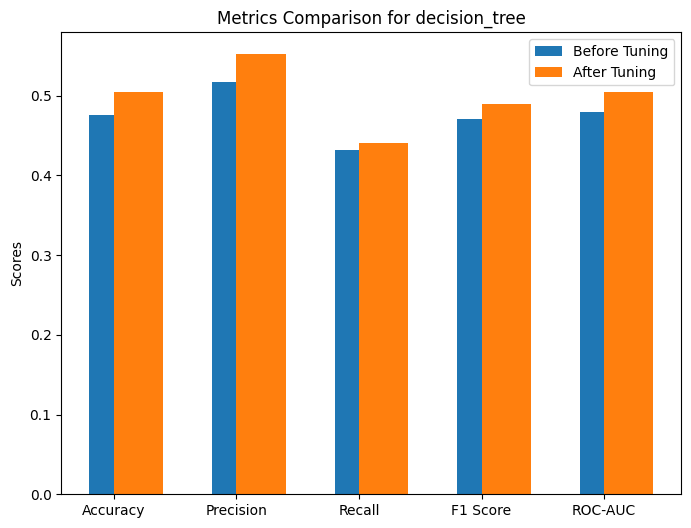

Metrics saved to decision_tree_Gender_metrics_comparison.txt


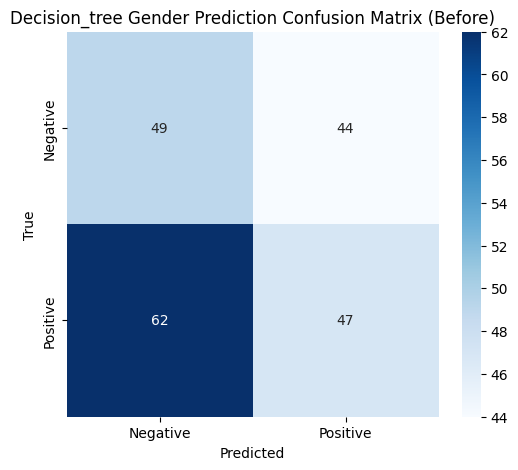

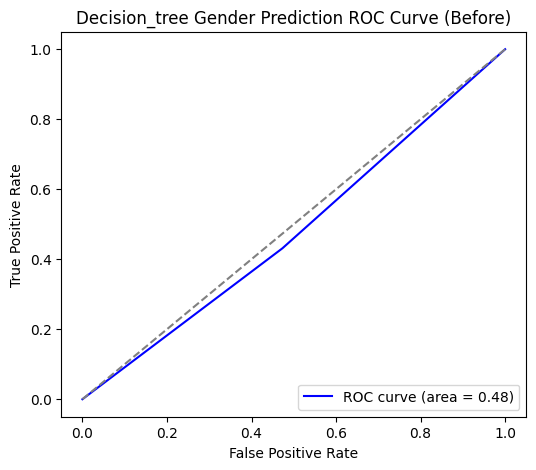

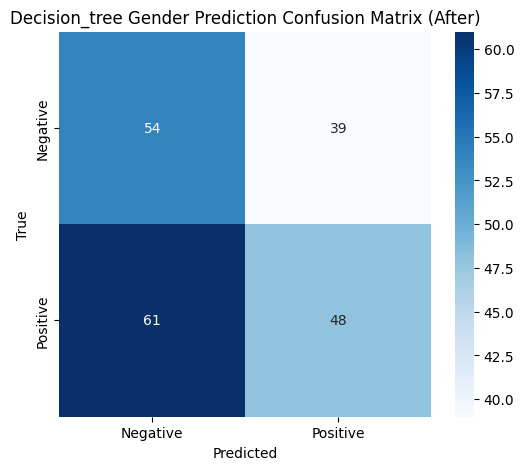

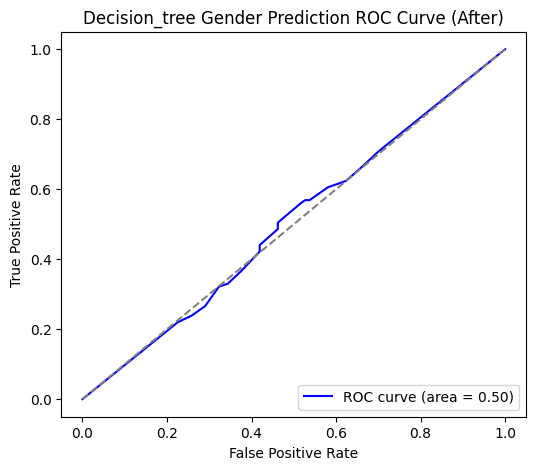

Model saved successfully to: ./models/decision_tree_Gender_model.pkl
---- Decision_tree Ad Click Prediction (Before Hyperparameter Tuning) ----
---- Hyperparameter Tuning for Decision_tree (Ad Click Prediction) ----
Best Parameters for decision_tree: {'classifier__criterion': 'entropy', 'classifier__max_depth': None, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10}

Metrics Comparison for decision_tree (Before and After Hyperparameter Tuning):
Metric              Before Tuning  After Tuning   
Accuracy            0.9406         0.9554         
Precision           0.9196         0.9450         
Recall              0.9717         0.9717         
F1 Score            0.9450         0.9581         
ROC-AUC             0.9390         0.9587         


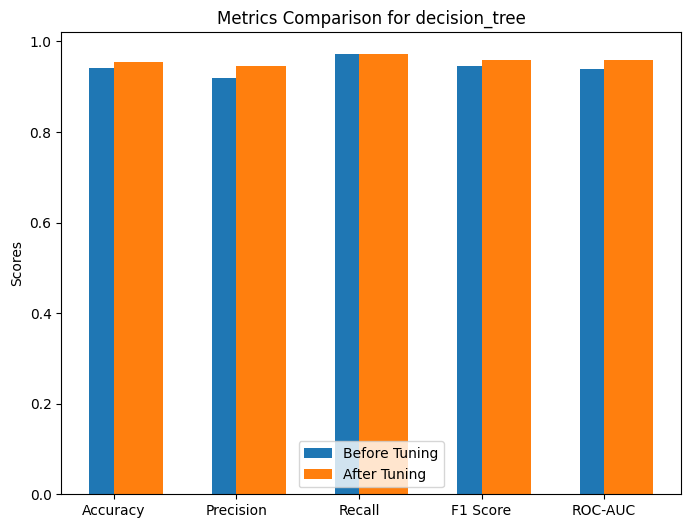

Metrics saved to decision_tree_Ad_click_metrics_comparison.txt


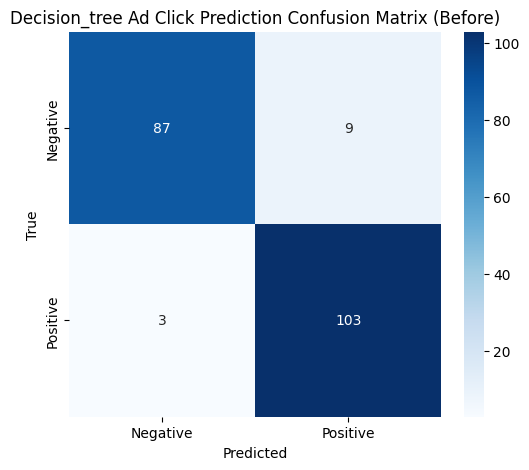

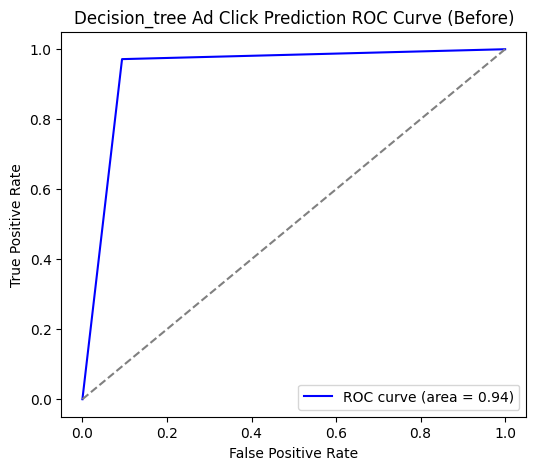

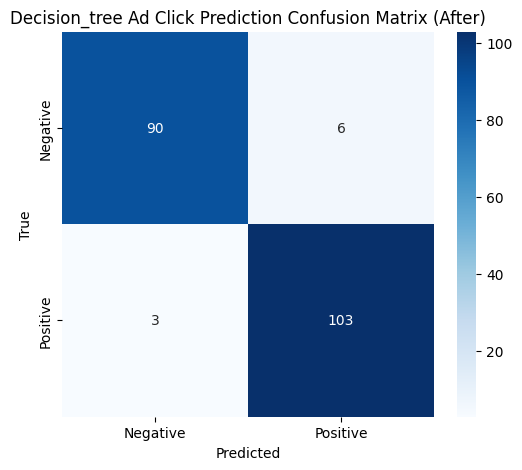

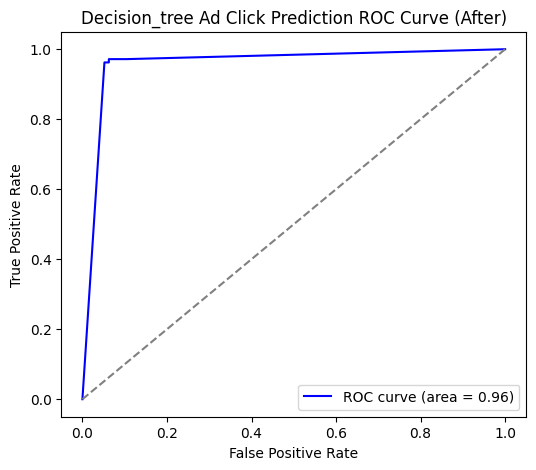

Model saved successfully to: ./models/decision_tree_Ad_click_model.pkl


'./models/decision_tree_Ad_click_model.pkl'

In [13]:
if __name__ == "__main__":
    # User input to select model
    model_name = input("Choose a model ('naive_bayes', 'svm', 'decision_tree'): ").strip().lower()

    # File path to the dataset
    file_path = 'advertising_ef.csv'

    # Features and targets
    features = ['Daily_Time_Spent_on_Site', 'Age', 'Area_Income', 'Daily_Internet_Usage']
    gender_target = 'Gender'
    ad_click_target = 'Clicked_on_Ad'

    # Specify the number of folds for hyperparameter tuning
    k = 5

    # Step 1: Load and preprocess data
    data = load_and_preprocess_data(file_path)

    # Step 2: Split data for gender prediction
    X_train_gender, X_test_gender, y_train_gender, y_test_gender = split_data(data, features, gender_target)

    # Step 3: Train model before hyperparameter tuning (default model)
    print(f"---- {model_name.capitalize()} Gender Prediction (Before Hyperparameter Tuning) ----")
    gender_pipeline = build_pipeline(model_name)
    before_metrics_gender = train_and_evaluate_pipeline(
        gender_pipeline, X_train_gender, X_test_gender, y_train_gender, y_test_gender
    )

    # Step 4: Hyperparameter tuning for gender prediction
    print(f"---- Hyperparameter Tuning for {model_name.capitalize()} (Gender Prediction) ----")
    best_gender_pipeline = tune_hyperparameters(
        X_train_gender, y_train_gender, model_name, k, 'roc_auc'
    )
    after_metrics_gender = train_and_evaluate_pipeline(
        best_gender_pipeline, X_train_gender, X_test_gender, y_train_gender, y_test_gender
    )

    target_name = 'Gender'

    # Step 5: Compare metrics before and after hyperparameter tuning for gender
    compare_metrics(
        before_metrics_gender[2:], after_metrics_gender[2:], model_name, target_name
    )
    save_metrics_to_file(
        before_metrics_gender[2:], after_metrics_gender[2:], model_name, target_name
    )

    # Step 6: Plot confusion matrix and ROC curve for gender prediction
    # Before tuning
    plot_confusion_matrix(
        y_test_gender,
        before_metrics_gender[0],
        model_name,
        target_name + '_Before',
        f"{model_name.capitalize()} Gender Prediction Confusion Matrix (Before)",
    )
    plot_roc_curve(
        y_test_gender,
        before_metrics_gender[1],
        model_name,
        target_name + '_Before',
        f"{model_name.capitalize()} Gender Prediction ROC Curve (Before)",
    )
    # After tuning
    plot_confusion_matrix(
        y_test_gender,
        after_metrics_gender[0],
        model_name,
        target_name + '_After',
        f"{model_name.capitalize()} Gender Prediction Confusion Matrix (After)",
    )
    plot_roc_curve(
        y_test_gender,
        after_metrics_gender[1],
        model_name,
        target_name + '_After',
        f"{model_name.capitalize()} Gender Prediction ROC Curve (After)",
    )

    # Step 7: Save the model after training
    save_model(best_gender_pipeline, model_name, target_name, directory='./models/')

# Step 7: Split data for ad click prediction
X_train_ad, X_test_ad, y_train_ad, y_test_ad = split_data(data, features, ad_click_target)

# Step 8: Train model before hyperparameter tuning for ad click prediction
print(f"---- {model_name.capitalize()} Ad Click Prediction (Before Hyperparameter Tuning) ----")
ad_pipeline = build_pipeline(model_name)
before_metrics_ad = train_and_evaluate_pipeline(ad_pipeline, X_train_ad, X_test_ad, y_train_ad, y_test_ad)

# Step 9: Hyperparameter tuning for ad click prediction
print(f"---- Hyperparameter Tuning for {model_name.capitalize()} (Ad Click Prediction) ----")
best_ad_pipeline = tune_hyperparameters(X_train_ad, y_train_ad, model_name, k, 'accuracy')
after_metrics_ad = train_and_evaluate_pipeline(best_ad_pipeline, X_train_ad, X_test_ad, y_train_ad, y_test_ad)

target_name = 'Ad_click'

# Step 10: Compare metrics before and after hyperparameter tuning for ad click prediction
compare_metrics(before_metrics_ad[2:], after_metrics_ad[2:], model_name, target_name)
# Save metrics to file
save_metrics_to_file(before_metrics_ad[2:], after_metrics_ad[2:], model_name, target_name)

# Step 11: Plot confusion matrix and ROC curve for ad click prediction
# Before tuning
plot_confusion_matrix(
    y_test_ad, before_metrics_ad[0], model_name, target_name + '_Before',
    f"{model_name.capitalize()} Ad Click Prediction Confusion Matrix (Before)"
)
plot_roc_curve(
    y_test_ad, before_metrics_ad[1], model_name, target_name + '_Before',
    f"{model_name.capitalize()} Ad Click Prediction ROC Curve (Before)"
)

# After tuning
plot_confusion_matrix(
    y_test_ad, after_metrics_ad[0], model_name, target_name + '_After',
    f"{model_name.capitalize()} Ad Click Prediction Confusion Matrix (After)"
)
plot_roc_curve(
    y_test_ad, after_metrics_ad[1], model_name, target_name + '_After',
    f"{model_name.capitalize()} Ad Click Prediction ROC Curve (After)"
)

# Step 12: Save the model after training
save_model(best_ad_pipeline, model_name, target_name, directory='./models/')
